<a href="https://colab.research.google.com/github/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/blob/main/IAP_T3_E1_JJTL_Entregable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad Nacional Autónoma de México
# Instituto de Investigaciones en Matemáticas Aplicadas y en Sistemas
# Introducción al Aprendizaje Profundo
# José de Jesús Tapia López
# Tarea 3: Transferencia de conocimiento y redes recurrentes
# 11 de Junio de 2021


## Ejercicio 1

1. Entrena modelos de regresión para predecir edades en el conjunto de datos [UTKFace](https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb). La solución debe cumplir con los siguientes puntos:

* Implementa la tubería de datos usando el conjunto de rostros alineados y recortados.
* Agrega acrecentamiento de datos usando un espejeo horizontal.
Particiona aleatoriamente en subconjuntos entrenamiento 80% y prueba 20%.
* Usando transferencia de conocimiento, entrena un modelo reentrenando solo la  última capa.
* Usando transferencia de conocimiento, entrena un modelo reentrenando toda la red.
* Discute el comportamiento de los modelos durante el entrenamiento y los resultados finales en ambos conjuntos.

## 1. Preparación

In [1]:
# Colab
! pip install torchinfo

### 1.1 Bibliotecas

In [2]:
# marcas de tiempo
import datetime
# explorar el sistema de archivos
import glob
# sistema de archivos
import os
# funciones aleatorias
import random
# marcas de tiempo
import time
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
from os.path import join

# gráficas
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
import torchvision.models as tvm
import torchvision.transforms as T
# leer archivo matlab
from scipy.io import loadmat
# cargador de datos
from torch.utils.data import DataLoader
# trazas de Tensorboard
from torch.utils.tensorboard import SummaryWriter
# inspección de arquitectura
from torchinfo import summary
# barra de progreso
from tqdm import tqdm
from tqdm.notebook import trange
# imágenes
from PIL import Image

# R^2
from sklearn.metrics import r2_score

### 1.2. Auxiliares

In [3]:
# directorio de datos (donde quiero que se descarguen mis datos)
DATA_DIR = '../datos'

# tamaño del lote
BATCH_SIZE = 32
# tamaño de la imagen
IMG_SIZE = 224

# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# filas y columnas de la cuadrícula 
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Despliega un ejempos en una cuadrícula."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos lote
    display_grid(x, titles, rows, cols, figsize)


def timestamp(fmt='%y%m%dT%H%M%S'):
    """Regresa la marca de tiempo."""
    return datetime.datetime.fromtimestamp(time.time()).strftime(fmt)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# reproducibilidad
set_seed()

## 2. Datos

### 2.1 Tuberias de datos con PyTorch

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/figs/comida_datos.svg" width="950" height="750" />

El DataLoader se encarga de empaquetar los ejemplos en un lote.

### 2.2 Conjunto de datos

Vamos a descargar los datos



In [4]:
tvu.download_and_extract_archive(
          url='https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download',
          download_root=DATA_DIR,
          filename='UTKFace.tar.gz',
          md5='ae1a16905fbd795db921ff1d940df9cc'
      )


Extracting ../datos/UTKFace.tar.gz to ../datos


In [5]:
images = os.listdir(DATA_DIR+'/UTKFace')


Edad:  10


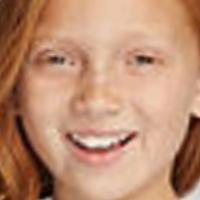

In [6]:
# mostramos un ejemplo
imag = Image.open(DATA_DIR+'/UTKFace/'+images[0])
print("Edad: ", int(images[0].split("_")[0]))
imag

In [7]:
# tamanio de la base de datos
len(images)

23708

In [8]:
class UTKFace:

    def __init__(self, root, subset, split=0.80, seed=0, transform=None):
        # guardamos atributos
        self.root = join(root, 'UTKFace')
        # proporcion de los datos de entrenamiento
        self.split = split
        # subconjunto de datos
        self.subset = subset
        # si aplicamos transformacion
        self.transform = transform
        
        imagenes = sorted(os.listdir(self.root))
        # fijamos el barajeo para reproducibilidad
        random.Random(seed).shuffle(imagenes) 
        # obtenemos la edad de cada participante
        edades = []
        for im in imagenes:
          edades.append(int(im.split("_")[0]))

        # hacemos la particion de datos en entrenamiento y prueba
        tamanio_trn = int(len(imagenes)*self.split) 
        if self.subset == "trn":
            self.imagenes = imagenes[:tamanio_trn]
            self.edades = edades[:tamanio_trn]
        elif self.subset == "tst":
            self.imagenes = imagenes[tamanio_trn:]
            self.edades = edades[tamanio_trn:]
        # subconjuntos solamente de entrenamiento y prueba
        else:
          ValueError(f'invalid value for subset={subset}')


    def __getitem__(self, i):
        # cargamos la imagen
        imagen = self.imagenes[i]
        img = Image.open(join(self.root,imagen))
        #print(self.root,imagen)
        # aplicamos transformación
        if self.transform is not None:
            img = self.transform(img)
        edad = self.edades[i]
 
        return img, edad

    def __len__(self):
        # regresamos numeros de ejemplos
        return len(self.imagenes)

In [9]:
ds_trn = UTKFace(DATA_DIR,'trn')

In [10]:
len(ds_trn)

18966

Imagen dimensiones=(200, 200) tipo=<class 'PIL.JpegImagePlugin.JpegImageFile'>
Edad int=54


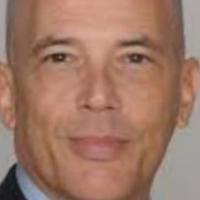

In [11]:
x, edad = ds_trn[4]
print(f'Imagen dimensiones={x.size} tipo={type(x)}')
print(f'Edad int={edad}')
x

### 2.3 Transformaciones

Torchvision tiene un conjunto de [transformaciones](https://pytorch.org/docs/1.6.0/torchvision/transforms.html) para ser ejecutadas de forma secuencial cuando se la pasamos a la clase `Compose`.

Vemos que en un principio no establecimos las transfromaciones, por lo que ahora sí vamos a incluir el espejeo horizontal.

In [12]:
# transformación de entrenamiento
trn_tsfm = T.Compose([
    # redimensionamos a Wx224 o 224xH
    T.Resize(IMG_SIZE),
    # aumentado de datos
    # espejeo horizontal aleatorio
    T.RandomHorizontalFlip(),
    # convertimos a torch.Tensor [3,H,W]
    # escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
# conjunto de entrenamiento
trn_ds =  UTKFace(DATA_DIR,'trn', transform=trn_tsfm)

In [13]:
# transformación de prueba
tst_tsfm = T.Compose([
    # redimensionamos a Wx224 o 224xH
    T.Resize(IMG_SIZE),
    # convertimos a torch.Tensor [3,H,W]
    # escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# conjunto de prueba
tst_ds = UTKFace(DATA_DIR,'tst', transform=tst_tsfm)

In [14]:
len(tst_ds)

4742

### 2.4 Cargadores de datos

Los [cargadores de datos](https://pytorch.org/docs/1.6.0/data.html) pueden precargar el siguiente lote de de entrenamiento forma paralela si especificamos `num_workers => 2`.

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/figs/data-loading1.png" />
<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/figs/data-loading2.png" />
Fuente: tensorflow.org

x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
edad shape=torch.Size([32]) dtype=torch.int64


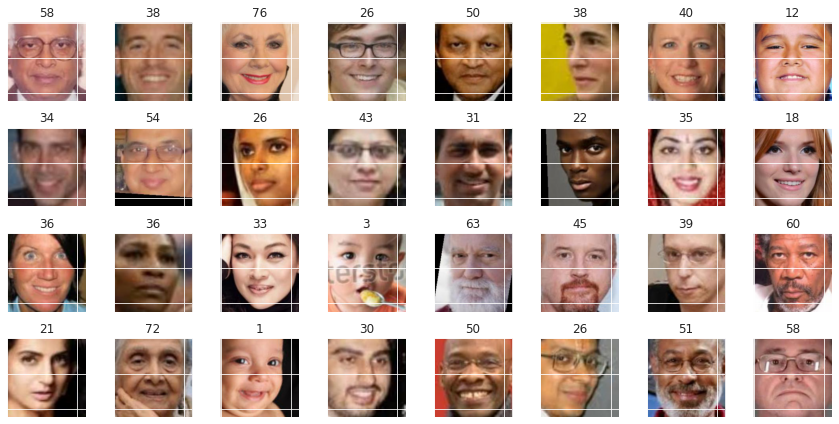

In [15]:
# creamos cargador
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # número de procesos paralelos
    num_workers=2
)
# desplegamos lote
x, edad  = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'edad shape={edad.shape} dtype={edad.dtype}')
display_batch(x, edad.numpy(), ROWS, COLS)

x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
edad shape=torch.Size([32]) dtype=torch.int64


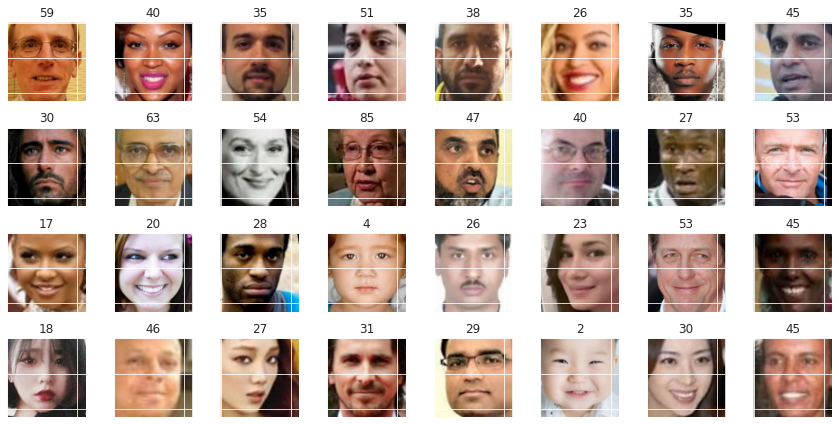

In [16]:
# creamos cargador
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # número de procesos paralelos
    num_workers=2
)
# desplegamos lote
x, edad = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'edad shape={edad.shape} dtype={edad.dtype}')
display_batch(x, edad.numpy(), ROWS, COLS)

## 3. Modelo: Shufflenet V2

Torchvision provee una familia de [modelos](https://pytorch.org/docs/1.6.0/torchvision/models.html#classification) preentrenados en ImageNet. Usaremos [Shufflenet V2](https://arxiv.org/abs/1807.11164) y Mobilenet V2. 

### 3.1 Carga de pesos

In [17]:
# instancia de modelo y carga de pesos
model = tvm.shufflenet_v2_x0_5(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

Podemos observar que el número de características en la última capa es: 1024. Además, necesitamos que sea un regresor, no un clasificador, por ello, hacemos las respectivas modificaciones.



In [19]:
class Reg(nn.Module):
    
    def __init__(self, pretrained):
        super(Reg, self).__init__()
        
        # cargamos el modelo
        self.cnn = tvm.shufflenet_v2_x0_5(pretrained=pretrained)
        # remplazamos la FC para dejar intactas 
        # las características (diablito)
        self.cnn.fc = nn.Identity()

        in_features = 1024
        # armamos la capa de regresión
        self.reg = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, 1)
        )
    
    def forward(self, x):
        # [N, 3, 224, 224] => [N, 1024]
        x = self.cnn(x)
        # [N, 1024] => [N, 1]
        x = self.reg(x)
        return x
    
model = Reg(True)


# congelamos (parametros de la red) y no van a requerir gradiente
for param in model.cnn.parameters():
  # no participa en la retropropagación
    param.requires_grad = False
# congelado de estadísticas de todo el modelo
#_ = model.eval()

### 3.2 Inspección de la arquitectura

In [20]:
summary(model, (1, 3, IMG_SIZE, IMG_SIZE), device='cuda', verbose=0)
#summary(model, (1, 3, IMG_SIZE, IMG_SIZE), device='cpu', verbose=0)

Layer (type:depth-idx)                        Output Shape              Param #
Reg                                           --                        --
├─ShuffleNetV2: 1-1                           [1, 1024]                 --
│    └─Sequential: 2-1                        [1, 24, 112, 112]         --
│    │    └─Conv2d: 3-1                       [1, 24, 112, 112]         (648)
│    │    └─BatchNorm2d: 3-2                  [1, 24, 112, 112]         (48)
│    │    └─ReLU: 3-3                         [1, 24, 112, 112]         --
│    └─MaxPool2d: 2-2                         [1, 24, 56, 56]           --
│    └─Sequential: 2-3                        [1, 48, 28, 28]           --
│    │    └─InvertedResidual: 3-4             [1, 48, 28, 28]           (2,400)
│    │    └─InvertedResidual: 3-5             [1, 48, 28, 28]           (1,512)
│    │    └─InvertedResidual: 3-6             [1, 48, 28, 28]           (1,512)
│    │    └─InvertedResidual: 3-7             [1, 48, 28, 28]           (1,

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

cuda


## 4. Entrenamiento
<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/figs/comida_entrenamiento.svg" width="650" />

## Entrenamos un modelo reentrenando solo la última capa.

In [22]:
# optimizador
opt = optim.Adam(model.parameters(), lr=1e-3)

# ciclo de entrenamiento
EPOCHS = 2
 # historiales
mse_hist, r2_hist = [], []
for epoch in range(EPOCHS):
    
    # capas de regresión en modo de entrenamiento
    model.reg.train()
       
    # entrenamiento de una época
    for x, y_true in tqdm(trn_dl, desc=f'E{epoch:2d} Train'):
        # movemos a dispositivo
        x = x.to(device)
        y_true = y_true.to(device)
        # computamos la prediccion
        y_pred = model(x)
        # computamos la pérdida
        loss = F.mse_loss(y_pred, y_true.view(-1,1).float())
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actualizamos parámetros
        opt.step()        

    # capas de regresión en modo de evaluación
    # no movemos las estadisticas de la capa de normalizacion
    model.reg.eval()    
    
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        mses, r2s = [], []
        # validación de la época
        for x, y_true in tqdm(tst_dl, desc=f'E{epoch:2d} Test '):
            # movemos a dispositivo
            x = x.to(device)
            y_true = y_true.to(device)
            # computamos la predicción
            y_pred = model(x)
            # computamos la pérdida
            mse = F.mse_loss(y_pred, y_true.view(-1,1).float())
            # computamos la r^2
            r2 = r2_score(y_true.detach().cpu().numpy(),y_pred.detach().cpu().numpy())
            # guardamos históricos
            mses.append(mse.item())
            r2s.append(r2.item())

        # promediamos métricas
        mse = np.mean(mses)
        R2 = np.mean(r2s)
        # guardamos historial
        mse_hist.append(R2)
        r2_hist.append(mse)
    # imprimimos métricas
    print(f'E{epoch:2} mse={mse:7.2f} R^2={R2:4.2f}')

E 1 Train:   0%|          | 0/593 [00:00<?, ?it/s]

E 0 mse= 182.97 R^2=0.48


E 1 Test : 100%|██████████| 149/149 [00:11<00:00, 13.33it/s]

E 1 mse= 174.17 R^2=0.49


In [23]:
mse_hist

[0.4801771560937796, 0.4910132253575983]

### Gráficas de pérdidas y $R^2$

No handles with labels found to put in legend.


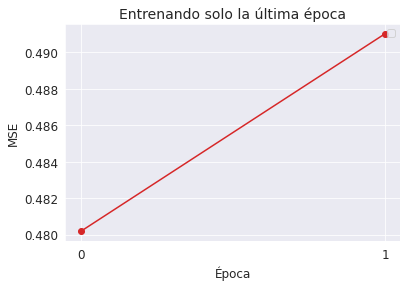

In [27]:
plt.plot(mse_hist, '-o',color='tab:red')
plt.legend(loc='upper right')
plt.xlabel('Época', fontsize=12)
plt.ylabel('MSE',fontsize=12)
plt.xticks(np.arange(0,EPOCHS), np.arange(0,EPOCHS), fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim(30,100)
plt.title('Entrenando solo la última época', fontsize=14)
plt.show()

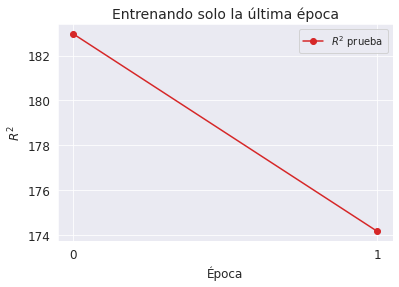

In [30]:
plt.plot(r2_hist, '-o',color='tab:red', label=r'$R^2$ prueba')
plt.legend(loc='upper right')
plt.xlabel('Época', fontsize=12)
plt.ylabel(r'$R^2$',fontsize=12)
plt.xticks(np.arange(0,EPOCHS), np.arange(0,EPOCHS), fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim(0.50,1.00)
plt.title('Entrenando solo la última época', fontsize=14)
plt.show()

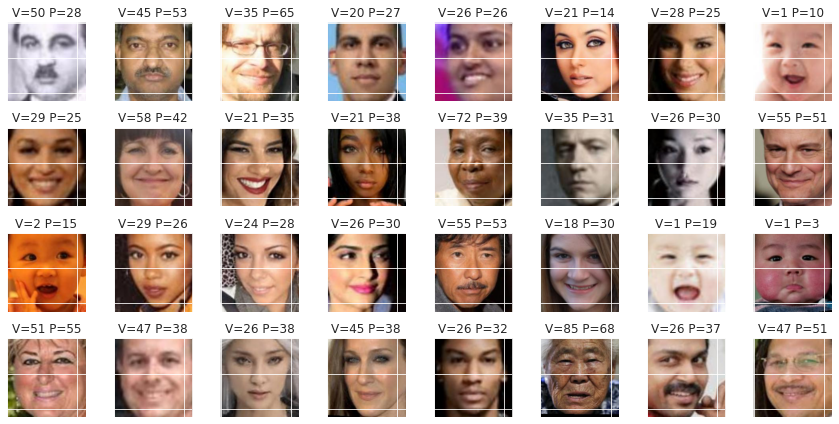

In [32]:
model.to("cpu")
with torch.no_grad():
    batch = next(iter(tst_dl))
    x, edad = batch
    y_pred = model(x).numpy().astype(int)
    titles = [f'V={t} P={p.item()}' for t, p in zip(edad, y_pred)]
    display_batch(x, titles, ROWS, COLS)

## Reentrenando todo el modelo

## AQUÍ TODAVÍA TENGO DUDA, POR ESO NO LO HE CORRIDO

In [ ]:
# instancia de modelo y carga de pesos
model2 = tvm.mobile_v2_x0_5(pretrained=True)

In [ ]:
model2 = Modelo(True)

# congelado de parámetros de la CNN
for param in model.cnn.parameters():
    param.requires_grad = True

model2

In [ ]:
summary(modelo2, (1, 3, 200, 200), device='cuda', verbose=0)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo2 = modelo2.to(device)
print(device)


In [ ]:
losses, R2_F = train(model, trn_dl, tst_dl, epochs=1, ultima_capa=False)

## Modelo: Mobilenet V2

In [37]:
# instancia de modelo y carga de pesos
model3 = tvm.mobilenet_v2(pretrained=True)
model3

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

Para este modelo, podemos observar que el número de características en la última capa es: 1280. Además, necesitamos que sea un regresor, no un clasificador, por ello, hacemos las respectivas modificaciones.

In [38]:
class Reg2(nn.Module):
    
    def __init__(self, pretrained):
        super(Reg2, self).__init__()
        
        # cargamos el modelo
        self.cnn = tvm.mobilenet_v2(pretrained=pretrained)
        # remplazamos la FC para dejar intactas 
        # las características (diablito)
        self.cnn.classifier = nn.Identity()

        in_features = 1280
        # armamos la capa de regresión
        self.reg = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, 1)
        )
    
    def forward(self, x):
        # [N, 3, 224, 224] => [N, 1280]
        x = self.cnn(x)
        # [N, 1280] => [N, 1]
        x = self.reg(x)
        return x
    
model3 = Reg2(True)


# congelamos (parametros de la red) y no van a requerir gradiente
for param in model3.cnn.parameters():
  # no participa en la retropropagación
    param.requires_grad = False
# congelado de estadísticas de todo el modelo
#_ = model3.eval()

In [39]:
summary(model3, (1, 3, 224, 224), device='cuda', verbose=0)

Layer (type:depth-idx)                             Output Shape              Param #
Reg2                                               --                        --
├─MobileNetV2: 1-1                                 [1, 1280]                 --
│    └─Sequential: 2-1                             [1, 1280, 7, 7]           --
│    │    └─ConvBNActivation: 3-1                  [1, 32, 112, 112]         (928)
│    │    └─InvertedResidual: 3-2                  [1, 16, 112, 112]         (896)
│    │    └─InvertedResidual: 3-3                  [1, 24, 56, 56]           (5,136)
│    │    └─InvertedResidual: 3-4                  [1, 24, 56, 56]           (8,832)
│    │    └─InvertedResidual: 3-5                  [1, 32, 28, 28]           (10,000)
│    │    └─InvertedResidual: 3-6                  [1, 32, 28, 28]           (14,848)
│    │    └─InvertedResidual: 3-7                  [1, 32, 28, 28]           (14,848)
│    │    └─InvertedResidual: 3-8                  [1, 64, 14, 14]           (21,

## Entrenamos un modelo reentrenando solo la última capa.